In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_loader
import pymc as pm
import arviz as az

In [46]:
df = data_loader.load_data()

X_cols = df.columns[1:-1]
y_col = df.columns[-1]

df_std = df.copy()
for col in X_cols:
    df_std[col] = (df[col] - df[col].mean()) / df[col].std()


In [47]:
df_std

avg_income  avg_prop_tax  \
statefip Date                                      
Alabama  2000-01-31   41917.384970     -0.907443   
         2000-02-29   41917.384970     -0.907443   
         2000-03-31   41917.384970     -0.907443   
         2000-04-30   41917.384970     -0.907443   
         2000-05-31   41917.384970     -0.907443   
...                            ...           ...   
Wyoming  2024-09-30  104455.891107     -1.170488   
         2024-10-31  104455.891107     -1.170488   
         2024-11-30  104455.891107     -1.170488   
         2024-12-31  104455.891107     -1.170488   
         2025-01-31  104455.891107     -1.170488   

                     proportion_American Indian/Aleut/Eskimo  \
statefip Date                                                  
Alabama  2000-01-31                                -0.558066   
         2000-02-29                                -0.558066   
         2000-03-31                                -0.558066   
         2000-04-30                                -0.558066   
         2000-05-31                                -0.558066   
...                                                      ...   
Wyoming  2024-09-30                                -0.113929   
         2024-10-31                                -0.113929   
         2024-11-30                                -0.113929   
         2024-12-31                                -0.113929   
         2025-01-31                                -0.113929   

                     proportion_Asian only  proportion_Black  \
statefip Date                                                  
Alabama  2000-01-31              -0.436767          2.203214   
         2000-02-29              -0.436767          2.203214   
         2000-03-31              -0.436767          2.203214   
         2000-04-30              -0.436767          2.203214   
         2000-05-31              -0.436767          2.203214   
...                                    ...               ...   
Wyoming  2024-09-30              -0.308663         -0.832110   
         2024-10-31              -0.308663         -0.832110   
         2024-11-30              -0.308663         -0.832110   
         2024-12-31              -0.308663         -0.832110   
         2025-01-31              -0.308663         -0.832110   

                     proportion_White  total_population  Median Home Price  
statefip Date                                                               
Alabama  2000-01-31         -1.157406         -0.008103       97080.984792  
         2000-02-29         -1.157406         -0.008103       97250.037728  
         2000-03-31         -1.157406         -0.008103       97363.306485  
         2000-04-30         -1.157406         -0.008103       97617.062414  
         2000-05-31         -1.157406         -0.008103       97900.085921  
...                               ...               ...                ...  
Wyoming  2024-09-30          0.802192         -0.873155      341148.869753  
         2024-10-31          0.802192         -0.873155      343849.922709  
         2024-11-30          0.802192         -0.873155      346044.040121  
         2024-12-31          0.802192         -0.873155      348280.758951  
         2025-01-31          0.802192         -0.873155      350224.417540  

[15351 rows x 8 columns]

In [48]:
dates = df_std.reset_index()['Date'].unique()
print(dates)
months = pd.DataFrame(np.arange(0, dates.size), index=dates)
states = df_std.reset_index()['statefip'].unique()

<DatetimeArray>
['2000-01-31 00:00:00', '2000-02-29 00:00:00', '2000-03-31 00:00:00',
 '2000-04-30 00:00:00', '2000-05-31 00:00:00', '2000-06-30 00:00:00',
 '2000-07-31 00:00:00', '2000-08-31 00:00:00', '2000-09-30 00:00:00',
 '2000-10-31 00:00:00',
 ...
 '2024-04-30 00:00:00', '2024-05-31 00:00:00', '2024-06-30 00:00:00',
 '2024-07-31 00:00:00', '2024-08-31 00:00:00', '2024-09-30 00:00:00',
 '2024-10-31 00:00:00', '2024-11-30 00:00:00', '2024-12-31 00:00:00',
 '2025-01-31 00:00:00']
Length: 301, dtype: datetime64[ns]


In [49]:
df_std['Month'] = np.tile(np.arange(0, dates.size), 51)
df_std[X_cols[4]]

statefip  Date      
Alabama   2000-01-31   -1.157406
          2000-02-29   -1.157406
          2000-03-31   -1.157406
          2000-04-30   -1.157406
          2000-05-31   -1.157406
                          ...   
Wyoming   2024-09-30    0.802192
          2024-10-31    0.802192
          2024-11-30    0.802192
          2024-12-31    0.802192
          2025-01-31    0.802192
Name: proportion_White, Length: 15351, dtype: float64

In [50]:
state_list = df_std.reset_index()['statefip'].unique()
state_code = {state: i for i, state in enumerate(state_list)}

states = df_std.reset_index()['statefip'].apply(lambda x: state_code[x]).values
states

array([ 0,  0,  0, ..., 50, 50, 50])

In [51]:
coords = {'state_idx': state_list}

with pm.Model(coords=coords) as model:
    state_idx = pm.MutableData('state', states, dims='obs_id')
    
    tax_data = pm.MutableData('tax', df_std[X_cols[0]], dims='obs_id')
    native_data = pm.MutableData('native', df_std[X_cols[1]], dims='obs_id')
    asian_data = pm.MutableData('asian', df_std[X_cols[2]], dims='obs_id')
    black_data = pm.MutableData('black', df_std[X_cols[3]], dims='obs_id')
    white_data = pm.MutableData('white', df_std[X_cols[4]], dims='obs_id')
    population_data = pm.MutableData('population', df_std[X_cols[5]], dims='obs_id')
    time_data = pm.MutableData('time', df_std['Month'], dims='obs_id')

    state_mu = pm.Normal('state_mu', mu=200000, sigma=100000)
    sigma_s = pm.Exponential('sigma_s', 1/50000)  # Encourages moderate variance
    state_time = pm.Normal('state_time', mu=0, sigma=1000)  # More reasonable scale
    obs_sigma = pm.HalfCauchy('obs_sigma', beta=100)  # Prior for data noise


    # Random intercept
    const = pm.Normal('const', mu=state_mu, sigma=sigma_s, dims='state_idx')
    time_slope = pm.Normal('time_slope', mu=state_time, sigma=100000, dims='state_idx')

    # Random slopes
    tax_slope = pm.Normal('tax_slope', mu=-0, sigma=20)
    native_slope = pm.Normal('native_slope', mu=0, sigma=10000)
    asian_slope = pm.Normal('asian_slope', mu=0, sigma=10000)
    black_slope = pm.Normal('black_slope', mu=0, sigma=10000)
    white_slope = pm.Normal('white_slope', mu=0, sigma=5000)
    population_slope = pm.Normal('population_slope', mu=0, sigma=0.5)  # Much tighter prior


    # Model
    y_hat = const[state_idx] + tax_slope * tax_data + native_slope * native_data + asian_slope * asian_data + black_slope * black_data + white_slope * white_data + population_slope * population_data + time_slope[state_idx] * time_data

    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=obs_sigma, observed=df[y_col], dims='obs_id')

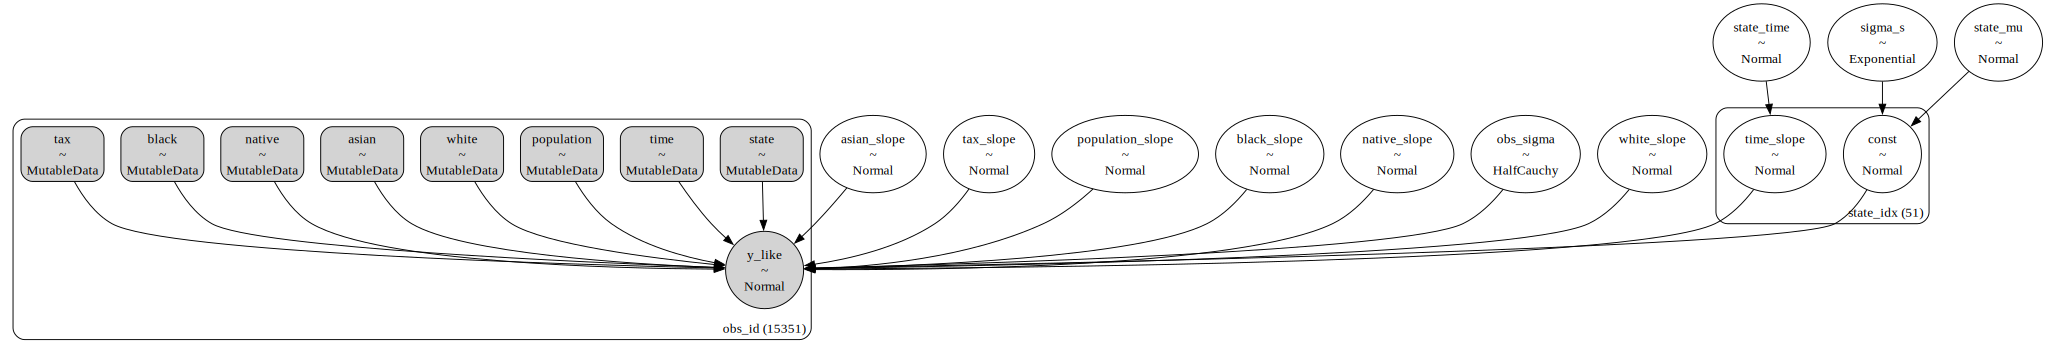

In [52]:
pm.model_to_graphviz(model)

In [53]:
with model:
    trace = pm.sample(
        2000, tune=2000, 
        target_accept=0.9, 
        return_inferencedata=True
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [state_mu, sigma_s, state_time, obs_sigma, const, time_slope, tax_slope, native_slope, asian_slope, black_slope, white_slope, population_slope]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 499 seconds.


/opt/homebrew/lib/python3.10/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (51) in plot_posterior, generating only 40 plots
  warnings.warn(


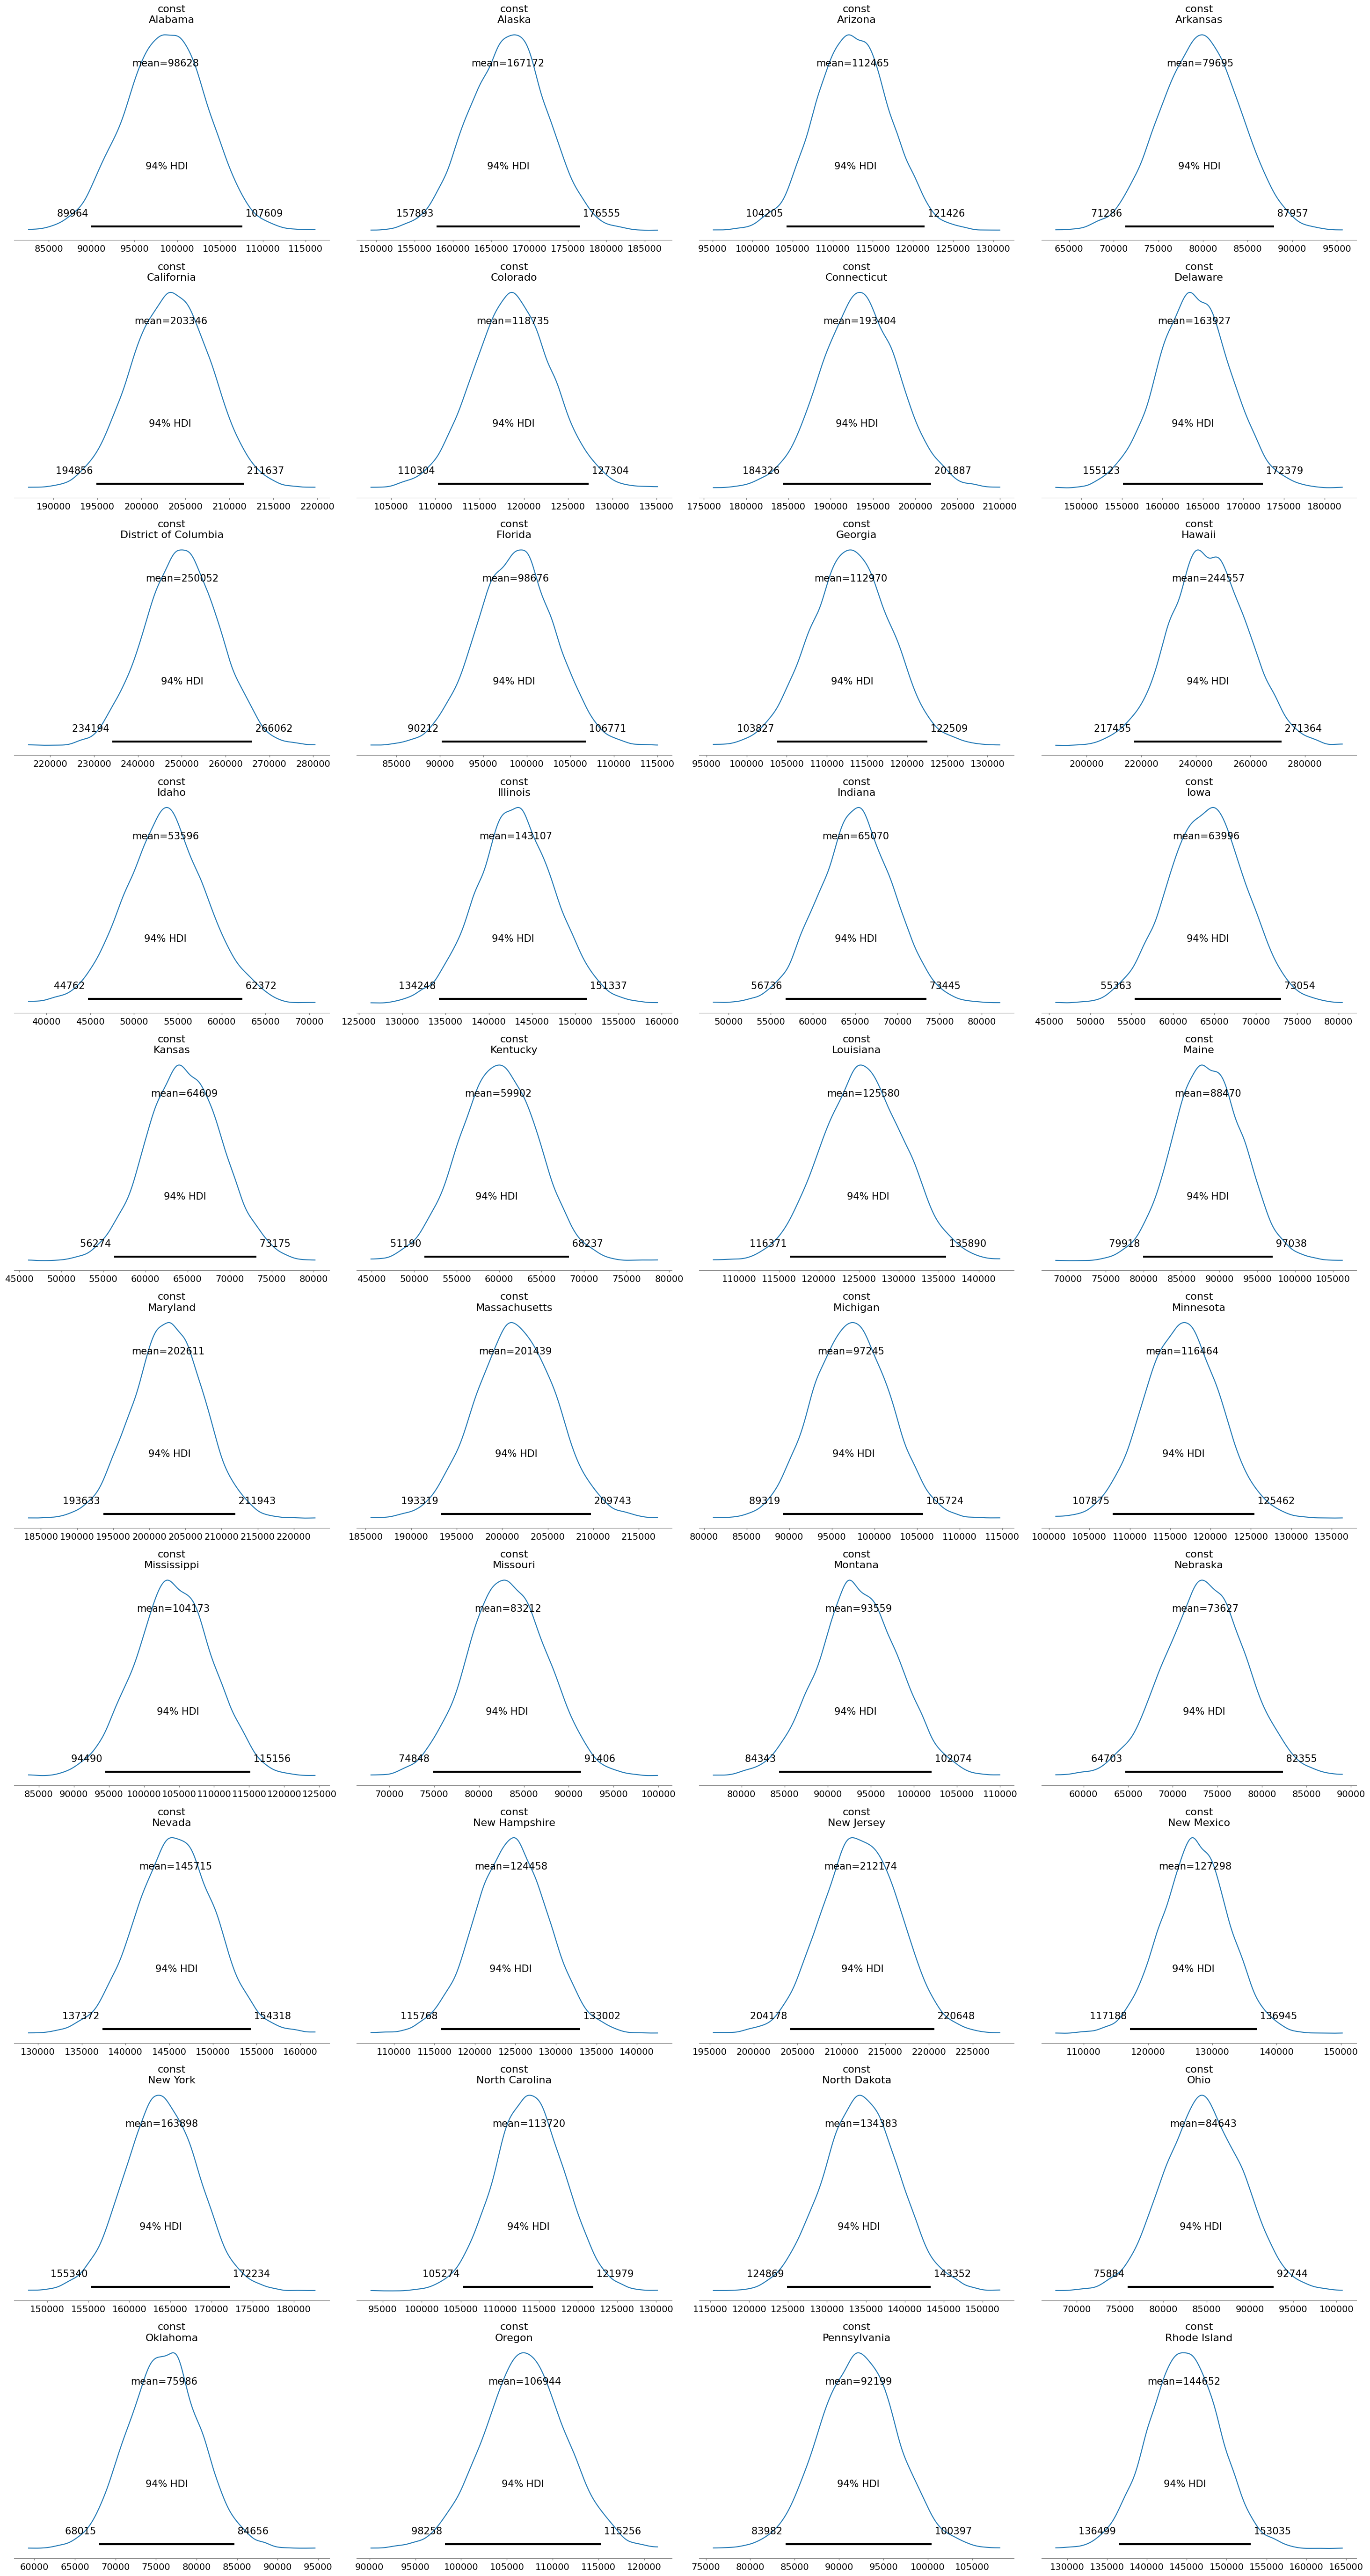

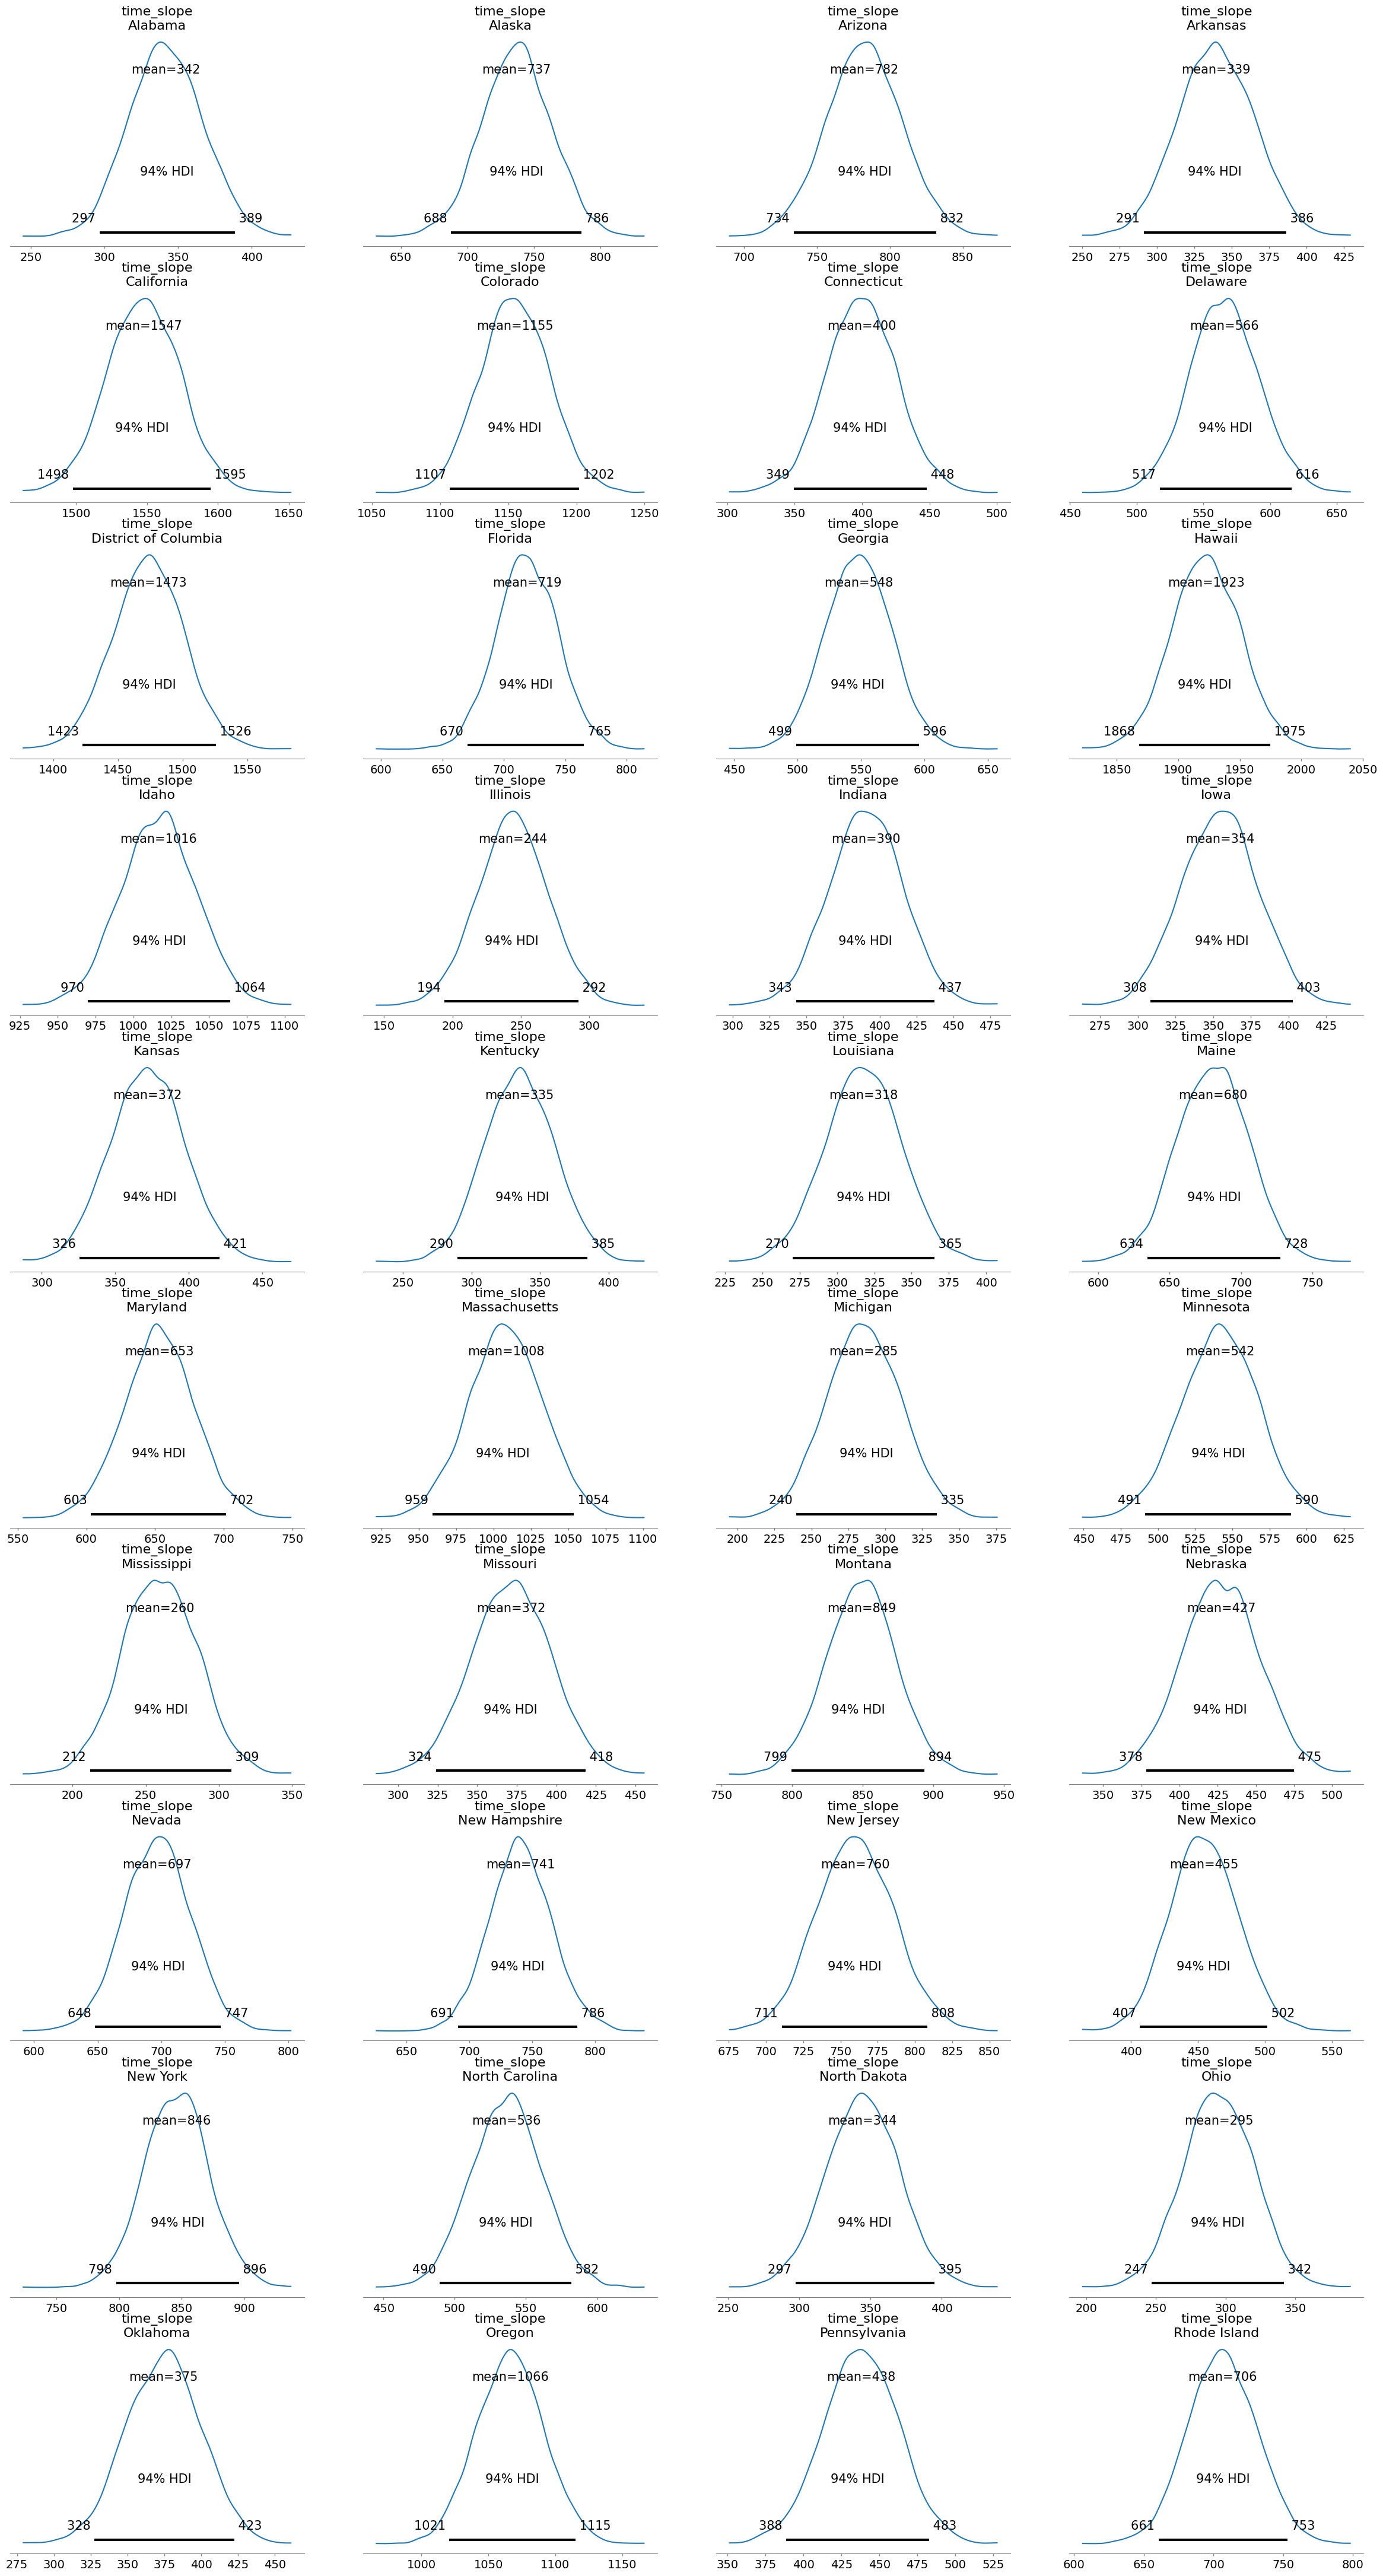

In [54]:
with model:
    import arviz as az
    az.plot_posterior(trace, var_names=['const'])
    plt.tight_layout()
    plt.show()

    az.plot_posterior(trace, var_names=['time_slope'])
    plt.show()

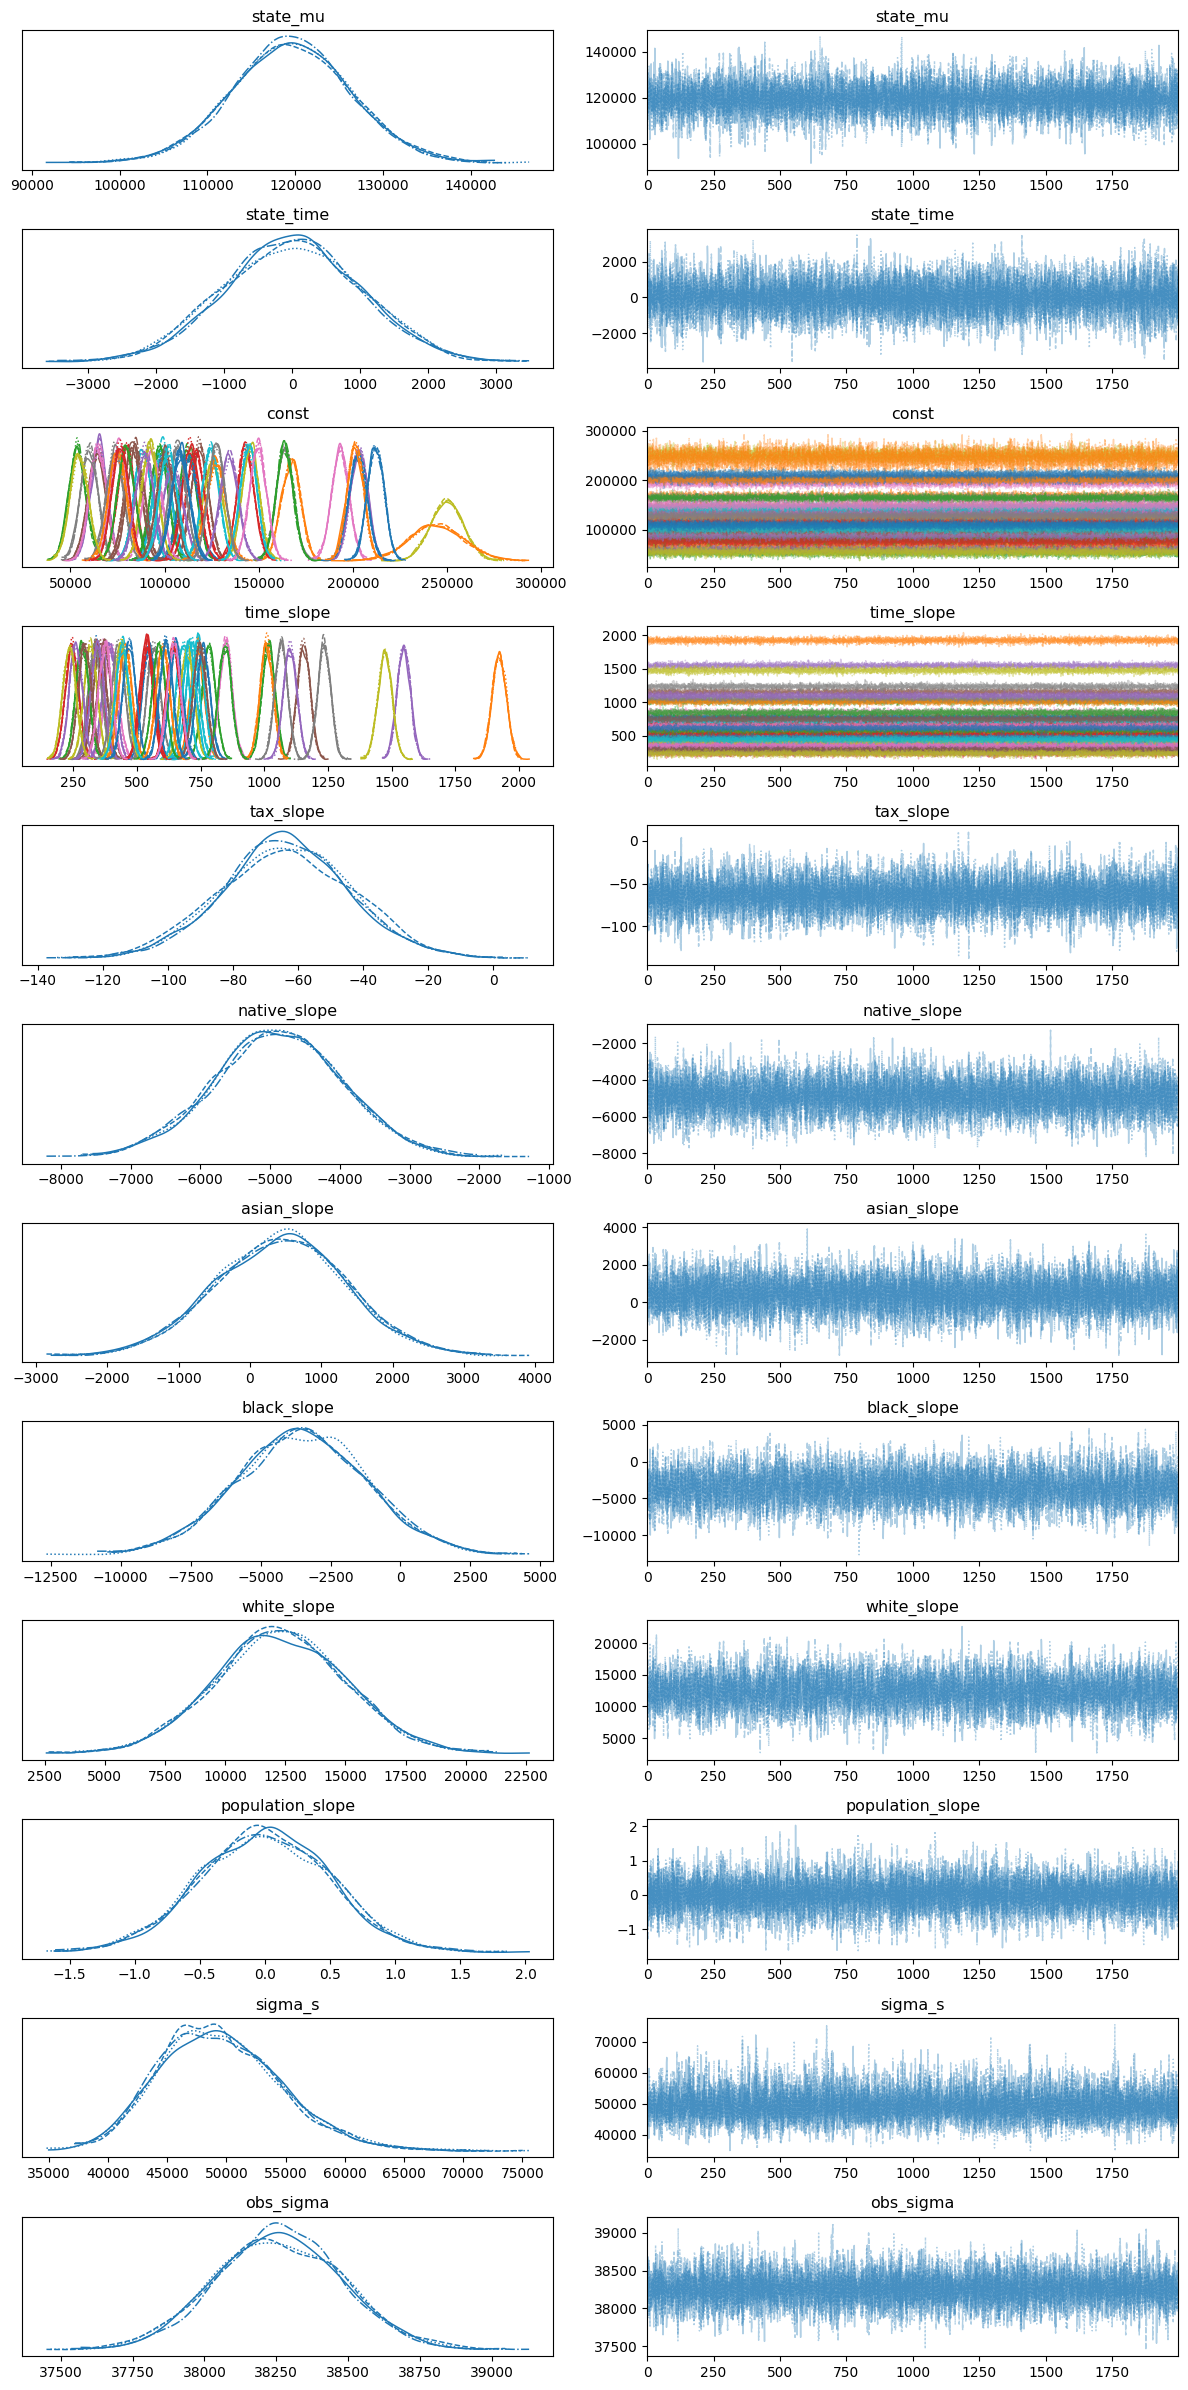

In [57]:
with model:
    az.plot_trace(trace)
    plt.tight_layout()
    plt.show()

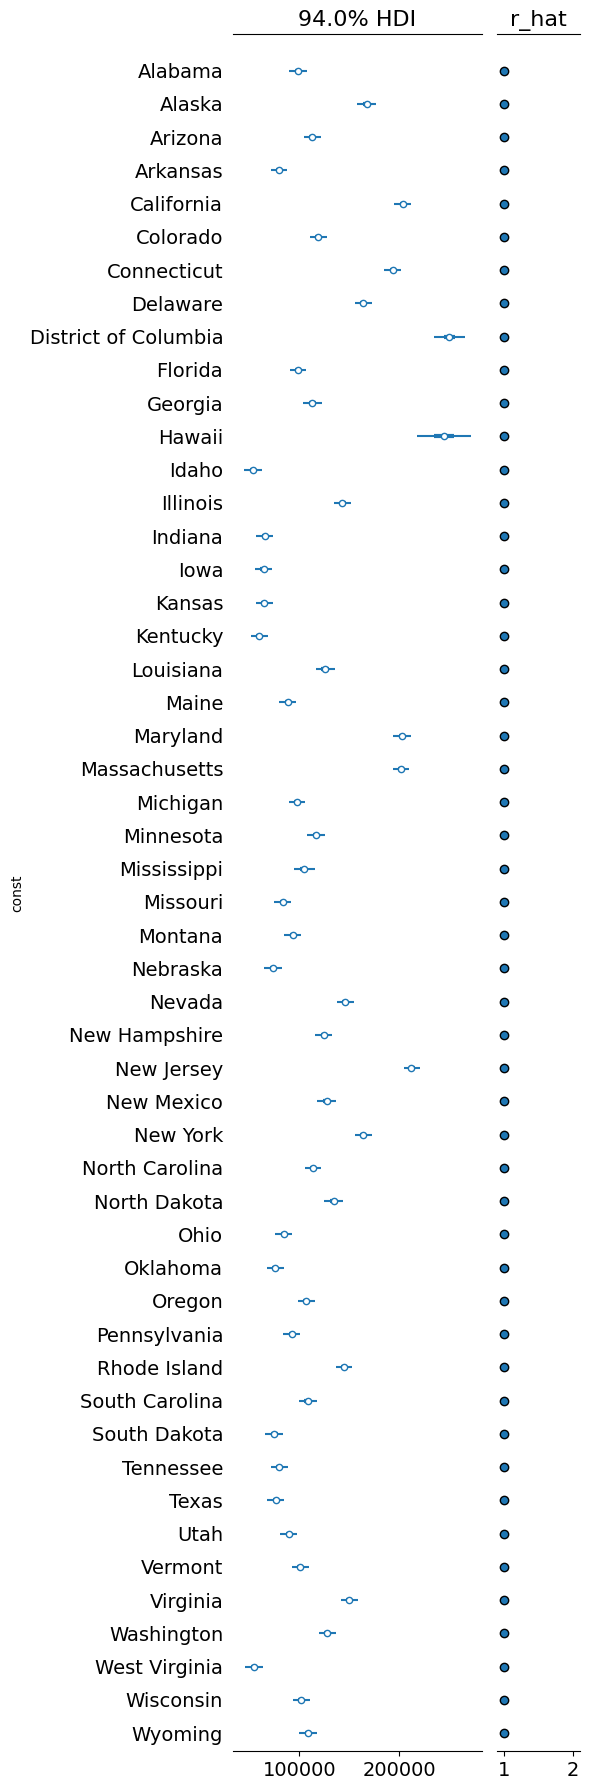

In [59]:
ax = pm.plot_forest(
    trace,
    var_names=["const"],
    figsize=(6, 18),
    combined=True,
    r_hat=True,
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("const")
plt.tight_layout()
plt.show()